In [349]:
!pip install requests

In [350]:
import requests

In [351]:
username = 'emma.c.j.schultz@gmail.com'
password = 'Possy0208!'


In [353]:
session = requests.Session()
response = session.post('https://posit.cloud/api/auth/login', json={'username': username, 'password': password})
response.raise_for_status()

In [565]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# Function to remove seasonal mean and divide by seadonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

In [597]:
# Function that makes El nino, La nina mask
# input data from correct years + 1 from the climate explorer
# set to False if we do NOT want to mask this value

def mask_maker(df_sstnino34):
    nino34list = df_sstnino34[:,1:].reshape(-1)

    nino34list = deTrend_deSeasonalize(nino34list, show_plot = False)

    nino34list_by_year = nino34list.reshape(-1,12)

    # NINO MASK
    
    ninamask = np.ones(len(nino34list)).reshape(-1,12)
    ninomask = np.ones(len(nino34list)).reshape(-1,12)

    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 > 0.5:
            ninomask[i,:] = False
    ninomask = ninomask[:len(ninomask)-1,:].reshape(-1)  
    
    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < -0.5:
            ninamask[i,:] = False
    ninamask = ninamask[:len(ninamask)-1,:].reshape(-1)  
    
    return ninomask, ninamask

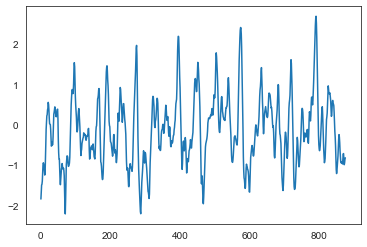

In [566]:
# Pick time range
start_year = 1950
length = 12*(2023 - start_year)

# Oceanic Nino Index defined by 5 consecutive months of 3-month-running-mean of Nino3.4 SST above/below 0.5
nino34 = np.loadtxt('iersst_nino3.4a.dat.txt', skiprows=44)[(start_year-1854)*12:(start_year-1854)*12+length,1]

nino34smoothed = pp.smooth(nino34, smooth_width=3, kernel='heaviside',mask=None, residuals=False)

plt.plot(nino34smoothed)

In [567]:
os.chdir('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data') 

#to check tigramite version
print(pkg_resources.get_distribution("tigramite").version)

5.2.0.2


In [568]:
reanalysis_data = np.vstack((
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = reanalysis_data.shape

In [569]:
# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC']

df_reanalysis = pd.DataFrame(reanalysis_data, columns=var_names)

In [570]:
dataframe_reanalysis = pp.DataFrame(reanalysis_data, 
                         datatime = np.arange(len(reanalysis_data)), 
                         var_names=var_names)

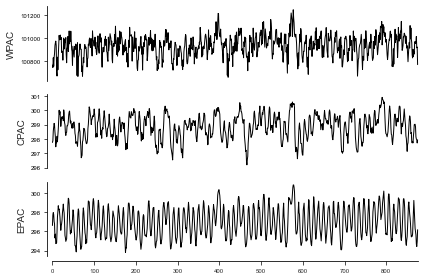

In [571]:
tp.plot_timeseries(dataframe_reanalysis); plt.show()

In [572]:
def deTrend_deSeasonalize(data, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data - smoothed
        return result

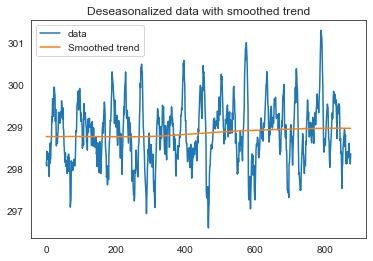

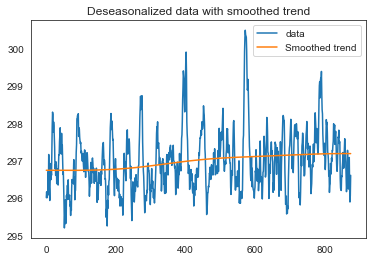

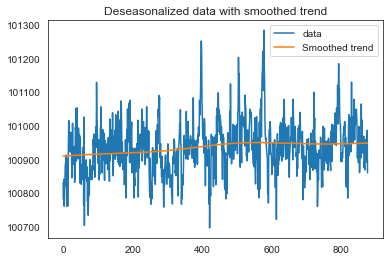

In [573]:
deTrend_deSeasonalize(df_reanalysis['CPAC'], show_plot = True)
plt.show()
deTrend_deSeasonalize(df_reanalysis['EPAC'], show_plot = True)
plt.show()
deTrend_deSeasonalize(df_reanalysis['WPAC'], show_plot = True)
plt.show()

In [574]:
cpac_detrend = deTrend_deSeasonalize(df_reanalysis['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df_reanalysis['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df_reanalysis['WPAC'], show_plot = False)

In [575]:
df_reanalysis_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})

In [576]:
dataframe = pp.DataFrame(df_reanalysis_processed.values, datatime = {0:np.arange(len(df))}, var_names= var_names)

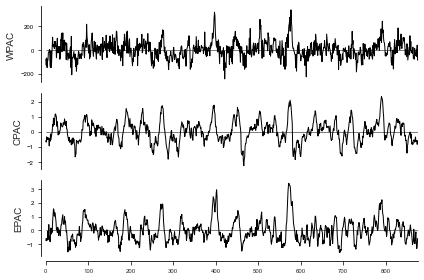

In [577]:
# Diagnostic plots

# tigramite data inspection
# plot 1: timeseries
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
plt.show()

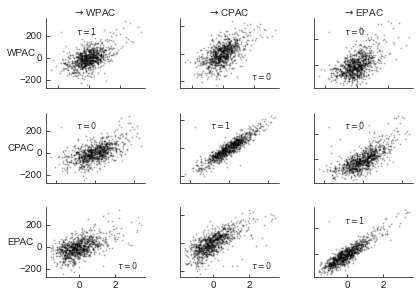

In [578]:
# plot 2: scatterplots
matrix_lags = None
tp.plot_scatterplots(dataframe=dataframe)
plt.show()

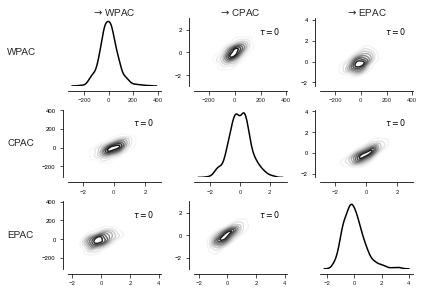

In [579]:
# plot 3: marginal and joint densities
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags})
plt.show()

In [580]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


In [581]:
# Causal network 1: All observations
pcmci.verbosity = 1
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nomask = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = None)



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 4 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.226
        (WPAC -2): max_pval = 0.00000, min_val =  0.170
        (WPAC -1): max_pval = 0.00000, min_val =  0.161
        (EPAC -2): max_pval = 0.00001, min_val =  0.151

    Variable CPAC has 6 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.724
        (EPAC -1): max_pval = 0.00000, min_val =  0.175
        (CPAC -3): max_pval = 0.00035, min_val = -0.121
        (WPAC -3): max_pval = 0.00110, min_val = -0.111
        (WPAC -1): max_pval = 0.00336, min_val =  0.099
        (EPAC -2): max_pval = 0.04592, min_val = -0.068

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.723
        (EPAC -3): max_pval = 0.00067, min_val = -0.115
  

In [582]:
parcorr = ParCorr(significance='analytic', mask_type='x')

In [583]:
# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

657


           WPAC      CPAC      EPAC
0    -79.296234 -0.610271 -0.731360
1   -129.155880 -0.699519 -0.577672
2    -69.593253 -0.349835 -0.738062
3   -149.537694 -0.535527 -0.646378
4    -86.942150 -0.440212 -0.673019
..          ...       ...       ...
871  -51.242548 -0.657228 -0.104040
872   -0.998765 -0.598107 -0.867484
873  -56.311569 -0.613870 -1.297366
874   38.154055 -0.845097 -1.125573
875  -87.932097 -0.603612 -0.582194

[876 rows x 3 columns]

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 1 link(s):
        (WPAC -2): max_pval = 0.02357, min_val =  0.187

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.586
        (WPAC -1): max_pval = 0.03522, min_val =  0.174
        (CPAC -3): max_pval = 0.03903, min_val = -0.171

    Variable EPAC has 1 lin

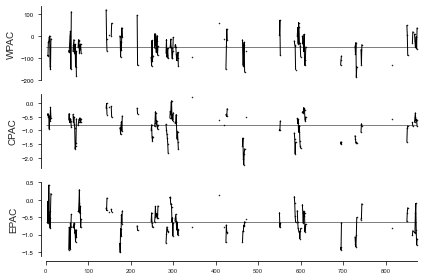

In [465]:
print(df_reanalysis_processed)
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_springbarrier = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = None)
# fdr_method = 'fdr_bh'

In [466]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
# Construct mask for spring barrier splitting to la nina
nina_mask = np.ones(length, dtype = 'bool')
for t in range(length):
    if np.sum(nino34smoothed[max(0, t-3): min(length, t+2)] < -0.5) >= 5:
        nina_mask[t] = False
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(springbarrier_mask.shape[0]):
    if nina_mask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

149



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 1 link(s):
        (WPAC -2): max_pval = 0.02357, min_val =  0.187

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.586
        (WPAC -1): max_pval = 0.03522, min_val =  0.174
        (CPAC -3): max_pval = 0.03903, min_val = -0.171

    Variable EPAC has 1 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.469

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable WPAC has 3 link(s):
        (CPAC -3): pval = 0.00123 | val =  0.268
        (WPAC -2): pval = 0.00184 | val =  0.255
        (WPAC -3): pval = 0.01002 | val =  0.213

    Variable CPAC has 2 link(s):
 

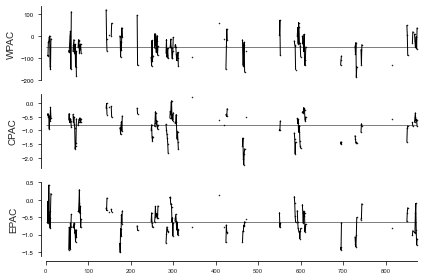

In [467]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nina = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = None)

In [468]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# maanden nov-dec-jan

# Construct mask for spring barrier splitting to el nino
nino_mask = np.ones(length, dtype = 'bool')
for t in range(length):
    if np.sum(nino34smoothed[max(0, t-2): min(length, t+3)] > 0.5) >= 5:
        nino_mask[t] = False
    
# Additionally mask to pick only neutral and La Nina phases
for t in range(springbarrier_mask.shape[0]):
    if nino_mask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

79



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 2 link(s):
        (WPAC -2): max_pval = 0.03728, min_val =  0.239
        (EPAC -2): max_pval = 0.04995, min_val =  0.223

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.661
        (EPAC -1): max_pval = 0.00207, min_val =  0.348
        (CPAC -3): max_pval = 0.00274, min_val =  0.333

    Variable EPAC has 2 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.768
        (EPAC -2): max_pval = 0.03793, min_val = -0.239

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable WPAC has 1 link(s):
        (WPAC -2): pval = 0.00375 | val =  0.329

    Variable CPAC ha

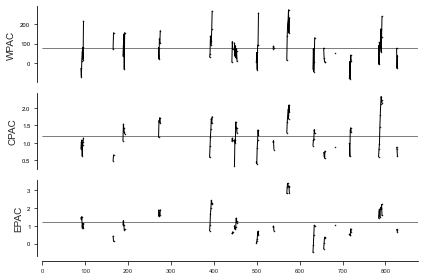

In [472]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nino = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = None)

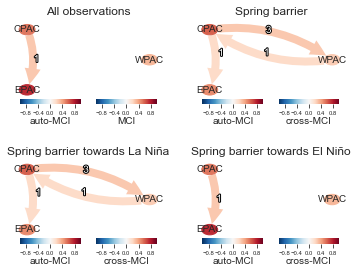

In [470]:
## PLOT ALL DAGS

fig, axes = plt.subplots(2, 2)

tp.plot_graph(
    val_matrix=results_nomask['val_matrix'],
    graph=results_nomask['graph'],
    var_names=var_names,
    fig_ax= (fig, axes[0,0]))
axes[0, 0].set_title('All observations')

tp.plot_graph(
    val_matrix=results_springbarrier['val_matrix'],
    graph=results_springbarrier['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[0,1]))
axes[0, 1].set_title('Spring barrier')

tp.plot_graph(
    val_matrix=results_nina['val_matrix'],
    graph=results_nina['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1,0]))
axes[1, 0].set_title('Spring barrier towards La Niña')

tp.plot_graph(
    val_matrix=results_nino['val_matrix'],
    graph=results_nino['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1,1]))
axes[1, 1].set_title('Spring barrier towards El Niño')

plt.subplots_adjust(hspace=0.8)
plt.show()

# NEW DATA: CESM2 model

In [539]:
# Pick time range
start_year = 1850
length = 12*(2023 - start_year)

CESM2_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_CESM2_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = CESM2_data.shape

In [540]:
# but skip first 100 years, so skip 12*100 = 1200 extra rows
CESM2_data = CESM2_data[1200:]

print(len(CESM2_data))

876


In [541]:
# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC']

df_CESM2 = pd.DataFrame(CESM2_data, columns=var_names)

In [542]:
dataframe_CESM2 = pp.DataFrame(CESM2_data, 
                         datatime = np.arange(len(CESM2_data)), 
                         var_names=var_names)

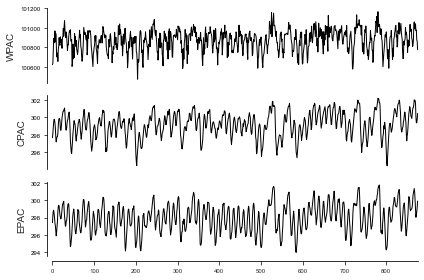

In [543]:
tp.plot_timeseries(dataframe_CESM2); plt.show()

In [544]:
cpac_detrend = deTrend_deSeasonalize(df_CESM2['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df_CESM2['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df_CESM2['WPAC'], show_plot = False)

In [545]:
df_CESM2_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})

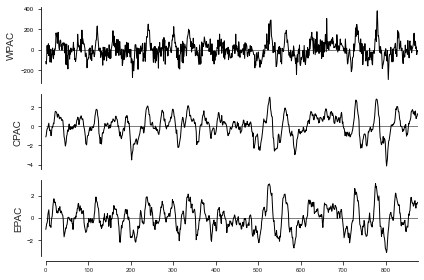

In [546]:
dataframe = pp.DataFrame(df_CESM2_processed.values, datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names)

tp.plot_timeseries(dataframe, color='black', show_meanline=True)
plt.show()

In [547]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


In [548]:
# Causal network 1: All observations
pcmci.verbosity = 1
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nomask = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 4 link(s):
        (WPAC -1): max_pval = 0.00000, min_val =  0.209
        (CPAC -2): max_pval = 0.00000, min_val =  0.178
        (WPAC -2): max_pval = 0.00103, min_val =  0.111
        (EPAC -2): max_pval = 0.01596, min_val =  0.082

    Variable CPAC has 7 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.722
        (EPAC -1): max_pval = 0.00000, min_val =  0.303
        (CPAC -3): max_pval = 0.00006, min_val = -0.136
        (WPAC -2): max_pval = 0.00165, min_val = -0.107
        (WPAC -3): max_pval = 0.00181, min_val = -0.106
        (WPAC -1): max_pval = 0.01177, min_val = -0.085
        (CPAC -2): max_pval = 0.01282, min_val = -0.084

    Variable EPAC has 4 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.787
  

In [549]:
parcorr = ParCorr(significance='analytic', mask_type='x')

In [550]:
# compute nino3.4 index for CESM2 model

# Pick time range
start_year = 1950
length = 12*(2023 - start_year)

nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)

nino34cesm2 = nino34cesm2[1200:2076,1:]

nino34cesm2_detrend = deTrend_deSeasonalize(nino34cesm2, show_plot = False)

plt.plot(nino34cesm2_detrend)

nino34cesm2_smoothed = pp.smooth(nino34cesm2_detrend, smooth_width=3, kernel='heaviside',
           mask=None, residuals=False)

plt.plot(nino34cesm2_smoothed)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [555]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend_deSeasonalize(nino34cesm2list, show_plot = False)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NINO MASK

for i in range(len(nino34cesm2list)-1):
    if (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 > 0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

ninomask = nino34cesm2list.reshape(-1)

nino_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        nino_count += 1

print(nino_count)
        

73
29


In [596]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

ninomask, ninamask = mask_maker(nino34cesm2)


29


In [556]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend_deSeasonalize(nino34cesm2list, show_plot = False)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NINA MASK

for i in range(len(nino34cesm2list)-1):
    if (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 < -0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

ninamask = nino34cesm2list.reshape(-1)

nina_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        nina_count += 1

print(nina_count)

73
25


In [557]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend_deSeasonalize(nino34cesm2list, show_plot = False)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NEUTRAL MASK

for i in range(len(nino34cesm2list)-1):
    if -0.5 < (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 < 0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

neutralmask = nino34cesm2list.reshape(-1)

neutral_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        neutral_count += 1

print(neutral_count)

73
19


In [558]:
# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

657


           WPAC      CPAC      EPAC
0   -116.253588 -1.121867 -1.027787
1   -141.211123 -0.956361 -0.773225
2    -78.687484 -0.541653 -0.527964
3     39.793021 -0.287755 -0.447484
4    -37.634193 -0.223657 -0.219105
..          ...       ...       ...
871    9.353197  0.821601  0.877052
872   26.248719  0.800222  1.287138
873  -48.402254  1.005444  1.195432
874   -8.843880  1.098786  1.307461
875  -19.616264  1.303565  1.402286

[876 rows x 3 columns]

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 5 link(s):
        (WPAC -1): max_pval = 0.00000, min_val =  0.235
        (WPAC -3): max_pval = 0.00113, min_val =  0.128
        (WPAC -2): max_pval = 0.00190, min_val =  0.121
        (CPAC -1): max_pval = 0.00748, min_val =  0.105
        (CPAC -3): max_pval = 0.04154, min_val =  0.080

    V

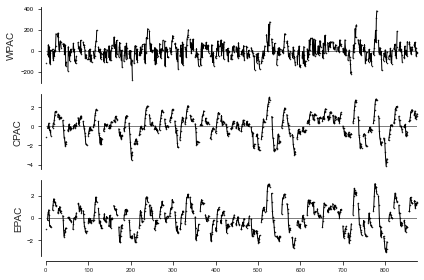

In [559]:
print(df_CESM2_processed)
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_springbarrier = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [560]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
# Construct mask for spring barrier splitting to la nina
nina_mask = np.ones(length, dtype = 'bool')
for t in range(len(nino34cesm2_smoothed)):
    if np.sum(nino34cesm2_smoothed[max(0, t-3): min(length, t+2)] < -0.5) >= 5:
        nina_mask[t] = False
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(springbarrier_mask.shape[0]):
    if ninamask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

225



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 2 link(s):
        (WPAC -1): max_pval = 0.00000, min_val =  0.401
        (WPAC -3): max_pval = 0.00040, min_val =  0.236

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.750
        (EPAC -1): max_pval = 0.02585, min_val =  0.150
        (WPAC -2): max_pval = 0.02588, min_val = -0.150

    Variable EPAC has 2 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.763
        (EPAC -2): max_pval = 0.00892, min_val = -0.175

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable WPAC has 2 link(s):
        (WPAC -1): pval = 0.00000 | val =  0.445
        (WPAC -3): pv

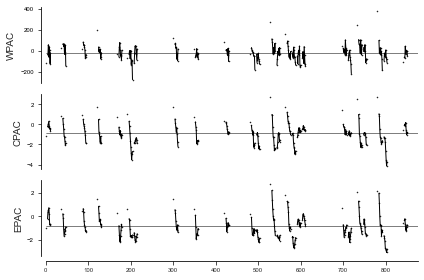

In [561]:
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nina = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [562]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# Construct mask for spring barrier splitting to el nino
nino_mask = np.ones(length, dtype = 'bool')
for t in range(length):
    if np.sum(nino34cesm2_smoothed[max(0, t-2): min(length, t+3)] > 0.5) >= 5:
        nino_mask[t] = False
    
# Additionally mask to pick only El Nino years 
for t in range(springbarrier_mask.shape[0]):
    if ninomask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

261



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 2 link(s):
        (CPAC -2): max_pval = 0.00070, min_val =  0.210
        (WPAC -1): max_pval = 0.03085, min_val =  0.135

    Variable CPAC has 4 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.786
        (EPAC -1): max_pval = 0.00019, min_val =  0.231
        (CPAC -3): max_pval = 0.00577, min_val = -0.172
        (EPAC -2): max_pval = 0.03277, min_val = -0.133

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.778
        (EPAC -2): max_pval = 0.00276, min_val = -0.186
        (CPAC -3): max_pval = 0.00540, min_val = -0.173

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha 

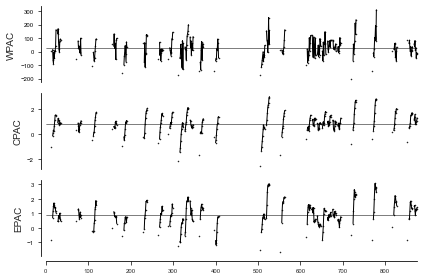

In [563]:
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nino = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

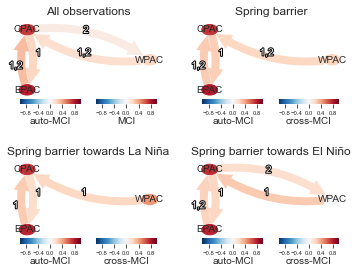

In [564]:
## PLOT ALL DAGS

fig, axes = plt.subplots(2, 2)

tp.plot_graph(
    val_matrix=results_nomask['val_matrix'],
    graph=results_nomask['graph'],
    var_names=var_names,
    fig_ax= (fig, axes[0,0]))
axes[0, 0].set_title('All observations')

tp.plot_graph(
    val_matrix=results_springbarrier['val_matrix'],
    graph=results_springbarrier['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[0,1]))
axes[0, 1].set_title('Spring barrier')

tp.plot_graph(
    val_matrix=results_nina['val_matrix'],
    graph=results_nina['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1,0]))
axes[1, 0].set_title('Spring barrier towards La Niña')

tp.plot_graph(
    val_matrix=results_nino['val_matrix'],
    graph=results_nino['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1,1]))
axes[1, 1].set_title('Spring barrier towards El Niño')

plt.subplots_adjust(hspace=0.8)
plt.show()